In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model.ARIMA import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import os


data = r"C:\Users\jim\Dropbox\Sample projects\Forecasting\data"
import warnings
warnings.filterwarnings('ignore')

## Import data

#### Import EURUSD


In [2]:
df = pd.read_csv(rf'{data}\EURUSD daily.csv')
df = df.iloc[6420:]
df.rename(columns = {'Last':'EURUSD'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "EURUSD"]]
df.reset_index(drop=True, inplace=True)
eur_usd = df.copy()
eur_usd.head()

,date,EURUSD
0,2000-01-03,1.0262
1,2000-01-04,1.0308
2,2000-01-05,1.0314
3,2000-01-06,1.0319
4,2000-01-07,1.0289


#### Import EU10yr Bund yields

In [3]:
df = pd.read_csv(rf'{data}\10yr Bund yields.csv')
df = df.iloc[274:]
df.rename(columns = {'Last':'EU10yr'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "EU10yr"]]
df.reset_index(drop=True, inplace=True)
eu10yr = df.copy()
eu10yr.head()

,date,EU10yr
0,2000-01-03,5.4708
1,2000-01-04,5.4801
2,2000-01-05,5.4801
3,2000-01-06,5.5402
4,2000-01-07,5.4256


#### Import UST yields


In [4]:
df = pd.read_csv(rf'{data}\10yr UST yields.csv')
df = df.iloc[9914:]
df.rename(columns = {'DGS10':'UST10yr', 'DATE': 'Date'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "UST10yr"]]
df.loc[df['UST10yr'] == ".", 'UST10yr'] = ""
df['UST10yr'] = pd.to_numeric(df['UST10yr'])
df.reset_index(drop=True, inplace=True)
ust10yr = df.copy()
ust10yr.head()

,date,UST10yr
0,2000-01-03,6.58
1,2000-01-04,6.49
2,2000-01-05,6.62
3,2000-01-06,6.57
4,2000-01-07,6.52


#### Import oil prices (WTI)

In [5]:
df = pd.read_csv(rf'{data}\WTI.csv')
df = df.iloc[4209:]
df.rename(columns = {'Last':'WTI'}, inplace = True)
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "WTI"]]
df.reset_index(drop=True, inplace=True)
wti = df.copy()
wti.head()

,date,WTI
0,2000-01-04,25.55
1,2000-01-05,24.91
2,2000-01-06,24.78
3,2000-01-07,24.22
4,2000-01-10,24.67


#### Import gold prices (XAU)

In [6]:
df = pd.read_csv(rf'{data}\XAU.csv', header=1)
df.rename(columns = {'Last(QXAU=)':'XAU'}, inplace = True)
df = df.iloc[::-1]
df['date'] = pd.to_datetime(df['Date'])
df = df[["date", "XAU"]]
df = df[df["date"]>="2000-01-01"]
df["XAU"] = df["XAU"].str.replace(',', '')
df["XAU"] = df["XAU"].astype(float)
df.reset_index(drop=True, inplace=True)
xau = df.copy()
xau.head()

,date,XAU
0,2000-01-03,288.50
1,2000-01-04,282.20
2,2000-01-05,280.75
3,2000-01-06,280.85
4,2000-01-07,281.50


# Merge and construct core dataset

In [7]:
print(len(eur_usd))
print(len(eu10yr))
print(len(ust10yr))
print(len(wti))
print(len(xau))

core = eur_usd.merge(eu10yr, how = "inner", on = "date")
core = core.merge(ust10yr, how = "inner", on = "date")
core = core.merge(wti, how = "inner", on = "date")
core = core.merge(xau, how = "inner", on = "date")

print(len(core))
core.head()


6181
6070
6181
5957
6171
5894


,date,EURUSD,EU10yr,UST10yr,WTI,XAU
0,2000-01-04,1.0308,5.4801,6.49,25.55,282.20
1,2000-01-05,1.0314,5.4801,6.62,24.91,280.75
2,2000-01-06,1.0319,5.5402,6.57,24.78,280.85
3,2000-01-07,1.0289,5.4256,6.52,24.22,281.50
4,2000-01-10,1.0253,5.3938,6.57,24.67,281.10


### Check if series is stationary

In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(eurusd):
    result=adfuller(eurusd)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations', 'CI']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis,indicating it is non-stationary ")

In [9]:
df = core.copy()
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df.set_index('date', inplace=True)

x1 = "EURUSD"
x2 = "EU10yr"
x3 = "UST10yr"
x4 = "WTI"
x5 = "XAU"

xvars = (x1, x2, x3, x4, x5)
df = df[[x1, x2, x3, x4, x5]]

df_difference = df.diff()
df_difference = df_difference.dropna()

for x in xvars:
    print("Stationarity test: levels for", x)
    adfuller_test(df[x])
    print(" ")  
    print("Stationarity test: first difference for", x)
    # Take first difference
    adfuller_test(df_difference[x].dropna())
    print(" ")

Stationarity test: levels for EURUSD
ADF Test Statistic : -1.8465035172984363
p-value : 0.357630414399961
#Lags Used : 11
Number of Observations : 5836
CI : {'1%': -3.4314710038754885, '5%': -2.862035378113867, '10%': -2.5670336876838284}
Weak evidence against null hypothesis,indicating it is non-stationary 
 
Stationarity test: first difference for EURUSD
ADF Test Statistic : -23.046497038434563
p-value : 0.0
#Lags Used : 10
Number of Observations : 5836
CI : {'1%': -3.4314710038754885, '5%': -2.862035378113867, '10%': -2.5670336876838284}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
 
Stationarity test: levels for EU10yr
ADF Test Statistic : -1.7245904469460218
p-value : 0.41848934041172203
#Lags Used : 0
Number of Observations : 5847
CI : {'1%': -3.4314688939964784, '5%': -2.862034445921537, '10%': -2.567033191451566}
Weak evidence against null hypothesis,indicating it is non-stationary 
 
Stationarity test: first difference for EU1

# VAR forecasts

### Train-Test Split and Grid Search for Order p, and forecast using VAR(p)

In [11]:
def minimum(a,b):
    if a<=b:
        return a
    else:
        return b

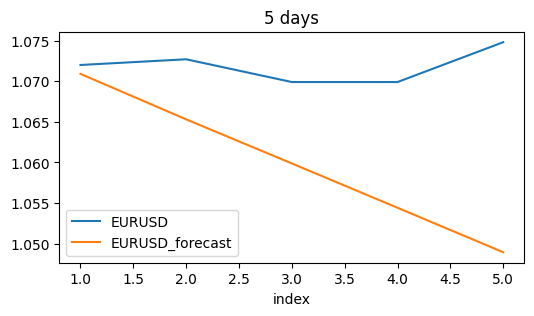

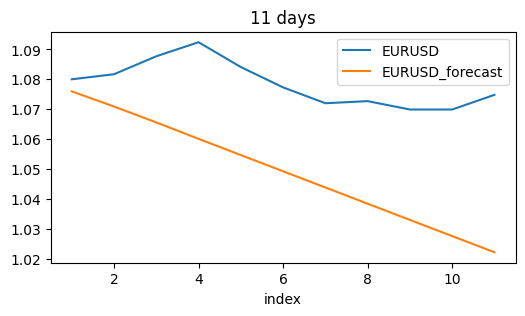

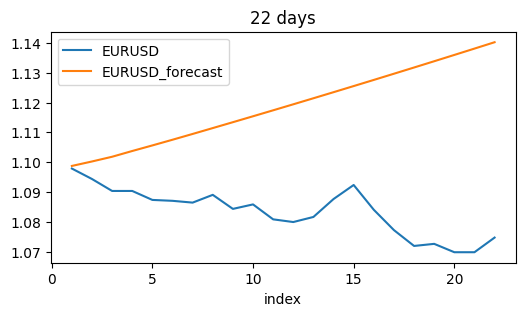

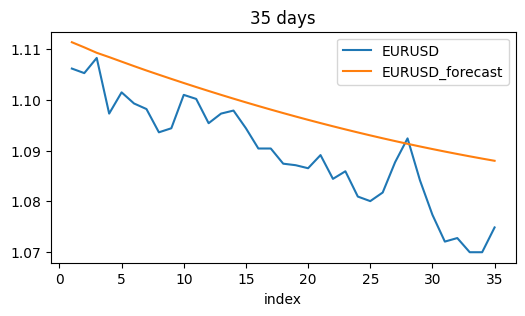

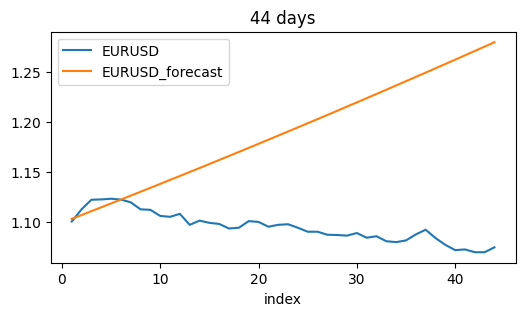

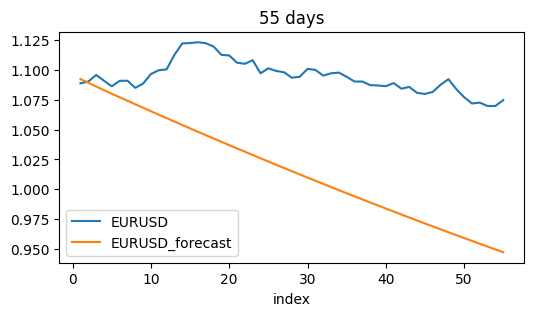

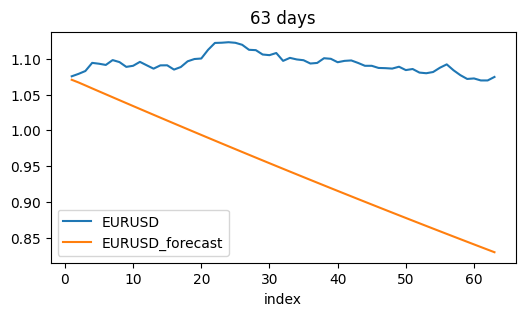

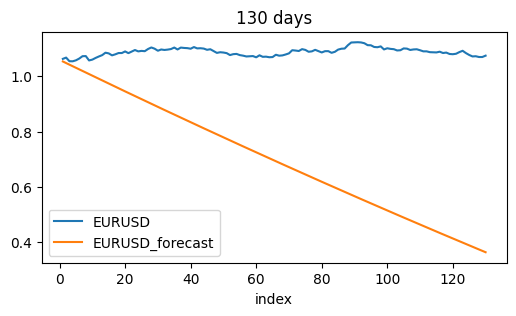

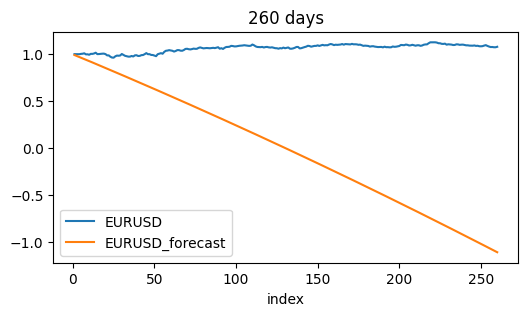

In [13]:
#Forecast the next x days (where x=test_obs)
test_obs = [5, 11, 22, 35, 44, 55, 63, 130, 260]
means = pd.DataFrame(index=np.arange(len(test_obs)), columns=np.arange(4))
means.rename(columns = {0:'Forecast_days' , 1:'EURUSD', 2: 'EURUSD_forecast', 3: 'MAPE'}, inplace = True)
r = 0
var_results = {}
daily_forecasts = {}
output_var = r'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\VAR\VAR daily'

df.reset_index(inplace=True, drop=True)

for t in test_obs:
    train = df_difference[:-t]
    test = df_difference[-t:]
    min_aic = np.nan
    
    for i in range(11):
        model = VAR(train)
        results = model.fit(i)
        min_aic = minimum(min_aic, results.aic)
        if min_aic == results.aic:
            p = i  
            
    result = model.fit(p)
    var_results[r] = f'{t} days Forecast', result.summary()
    lagged_Values = train.values[-p:]
    pred = result.forecast(y=lagged_Values, steps=t)     
    df_forecast=pd.DataFrame(data=pred, columns=[x1 + '_2d', x2 + '_2d', x3 + '_2d', x4 + '_2d', x5 + '_2d'])

    for x in xvars:
        df_forecast[x + '_1d'] = (df[x].iloc[-t-1]-df[x].iloc[-t-2]) + df_forecast[x + '_2d'].cumsum()
        df_forecast[x + '_forecast'] = df[x].iloc[-t-1] + df_forecast[x + '_1d'].cumsum()
        
    test_original = df[-t:]
    test_original.reset_index(inplace=True, drop=True)
    df_forecast["date"] = df_forecast.index
    test_original["date"] = test_original.index    

    var = x1
    df_forecast[var + "_MAPE"] = np.nan
    for i in range(t):
        df_forecast[var + "_MAPE"][i] = np.mean(np.abs(df_forecast[var + "_forecast"][i] - test_original[var][i])/np.abs(test_original[var][i]))
    
    daily_forecasts[r] = pd.merge(df_forecast[["EURUSD_forecast", "EURUSD_MAPE"]],test_original[["EURUSD"]], left_index=True,right_index=True) 
    daily_forecasts[r]["Day"] = daily_forecasts[r].index + 1
    daily_forecasts[r] = daily_forecasts[r][["Day", "EURUSD", "EURUSD_forecast", "EURUSD_MAPE"]] 
    
    means["Forecast_days"][r] = t
    means["EURUSD"][r] = test_original[var].mean()
    means["EURUSD_forecast"][r] = df_forecast[var + "_forecast"].mean()
    means["MAPE"][r] = np.mean(np.abs(df_forecast[var + "_forecast"] - test_original[var])/np.abs(test_original[var]))
    
    test_original["index"] = test_original.index + 1
    test_original.set_index('index', inplace=True)
    df_forecast["index"] = df_forecast.index + 1
    df_forecast.set_index('index', inplace=True)
    test_original[x1].plot(figsize=(6,3),legend=True)
    df_forecast[x1 + '_forecast'].plot(legend=True)
    plt.legend()
    plt.title(f'{t} days')
    file_name = f'plot_{t}_days_forecast.png'
    file_path = os.path.join(output_var, file_name)
    plt.savefig(file_path)
    plt.show()
    
    r=r+1
    
means.head() 

dataframes = [daily_forecasts[0], 
              daily_forecasts[1],
              daily_forecasts[2],
              daily_forecasts[3],
              daily_forecasts[4],
              daily_forecasts[5],
              daily_forecasts[6],
              daily_forecasts[7],
              daily_forecasts[8]]

with pd.ExcelWriter(rf'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\VAR\VAR daily\EURUSD_VAR.xlsx', engine='openpyxl') as writer:
     for i, daily_forecasts[r] in enumerate(dataframes, start=1):
        sheet_name = f'{len(daily_forecasts[r])} days forecast'
        daily_forecasts[r].to_excel(writer, sheet_name=sheet_name, index=False)      
        
   
     sheet_name = 'Mean forecasts'
     means.to_excel(writer, sheet_name=sheet_name, index=False)      

var_results = pd.DataFrame(var_results)
var_results.to_excel(rf'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\VAR\VAR daily\VAR_summary.xlsx')        

# ARIMA forecasts

Forecasts ahead: 5
Forecasts ahead: 11
Forecasts ahead: 22
Forecasts ahead: 35
Forecasts ahead: 44
Forecasts ahead: 55
Forecasts ahead: 63
Forecasts ahead: 130
Forecasts ahead: 260


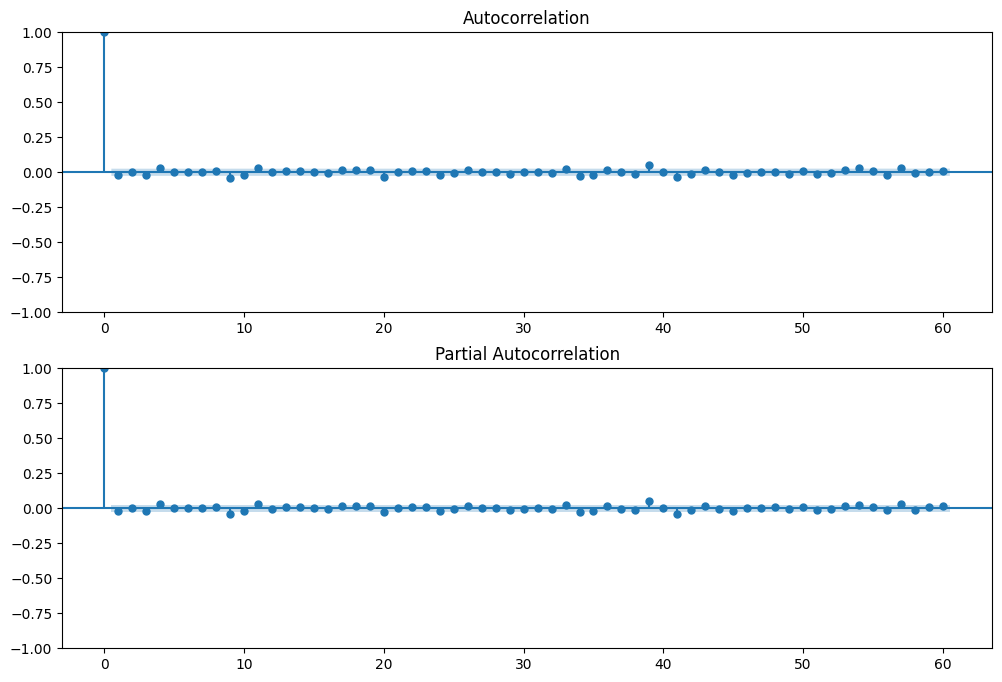

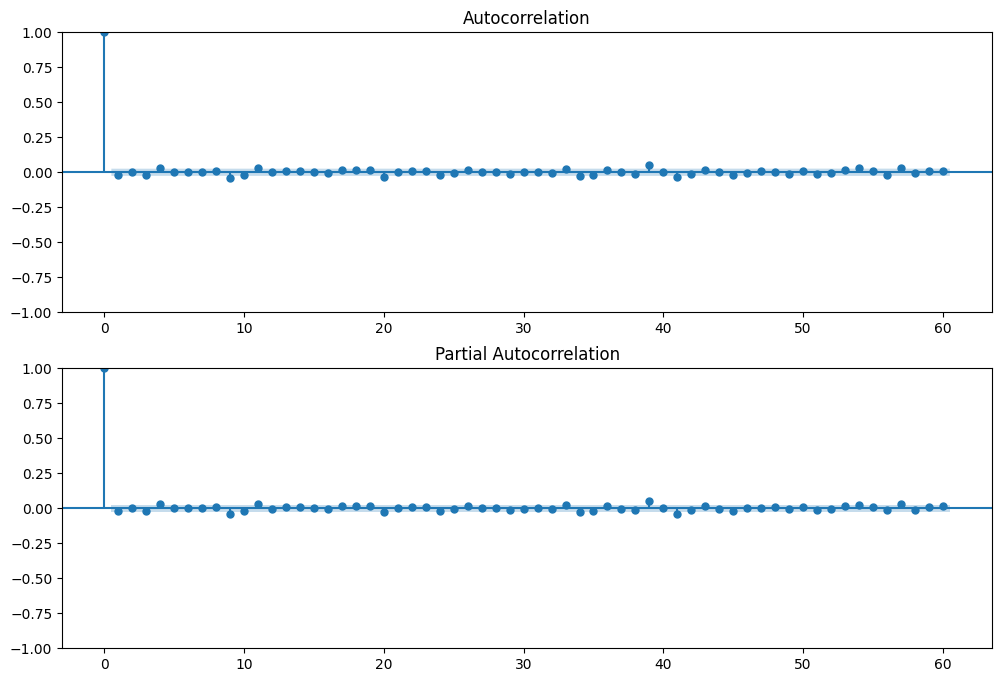

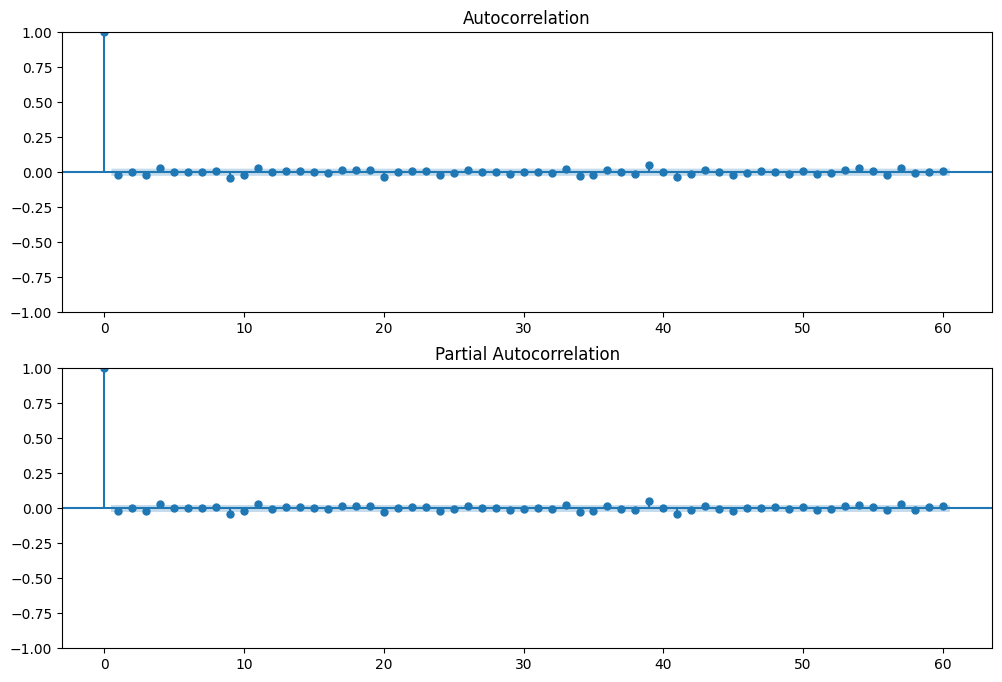

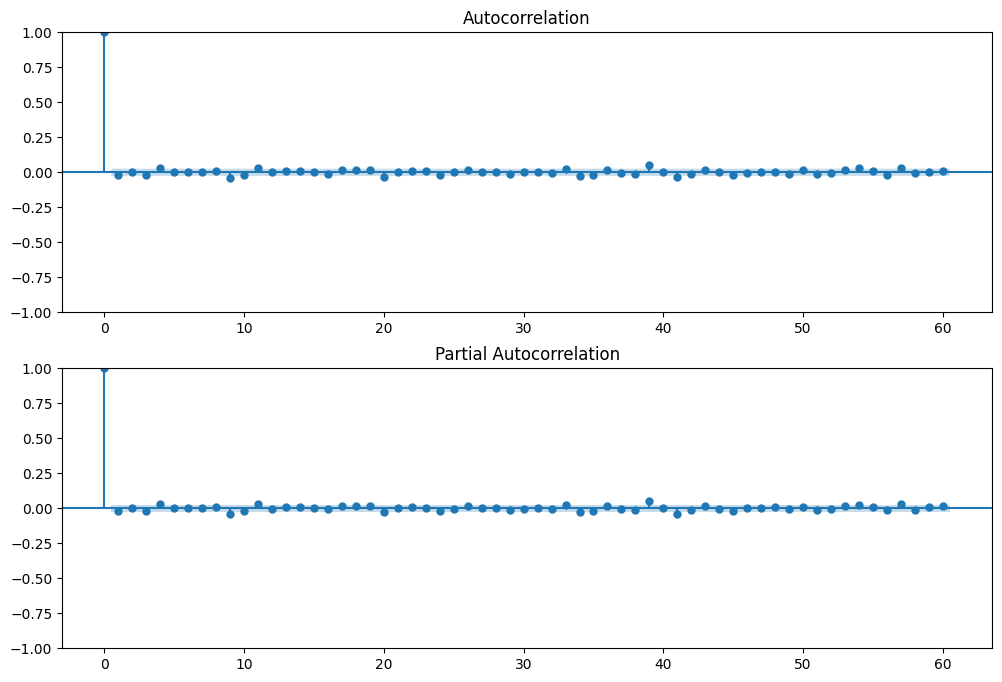

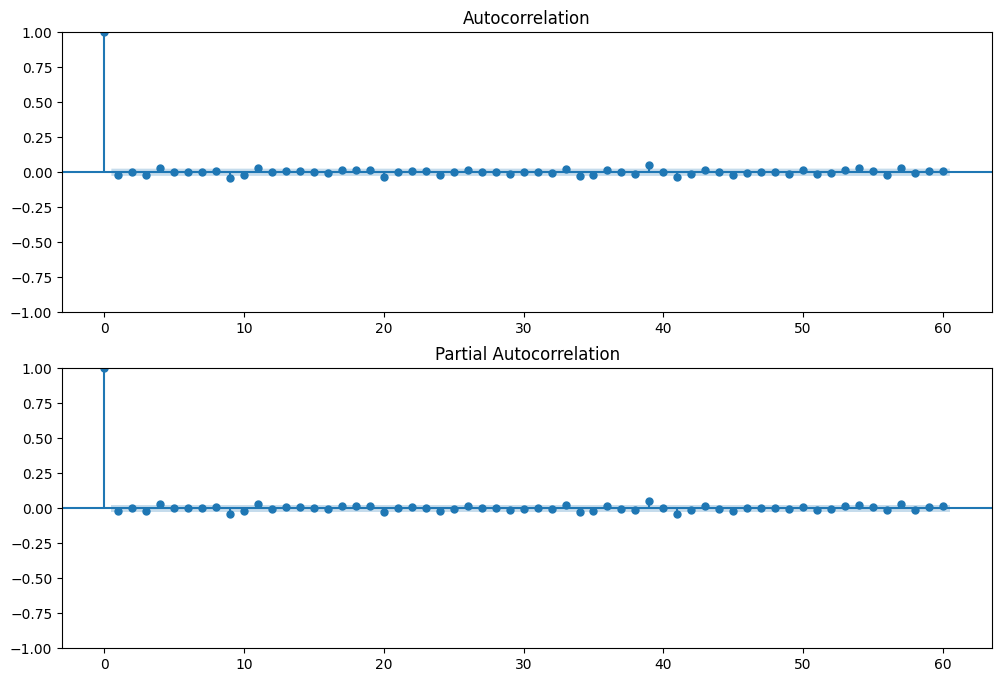

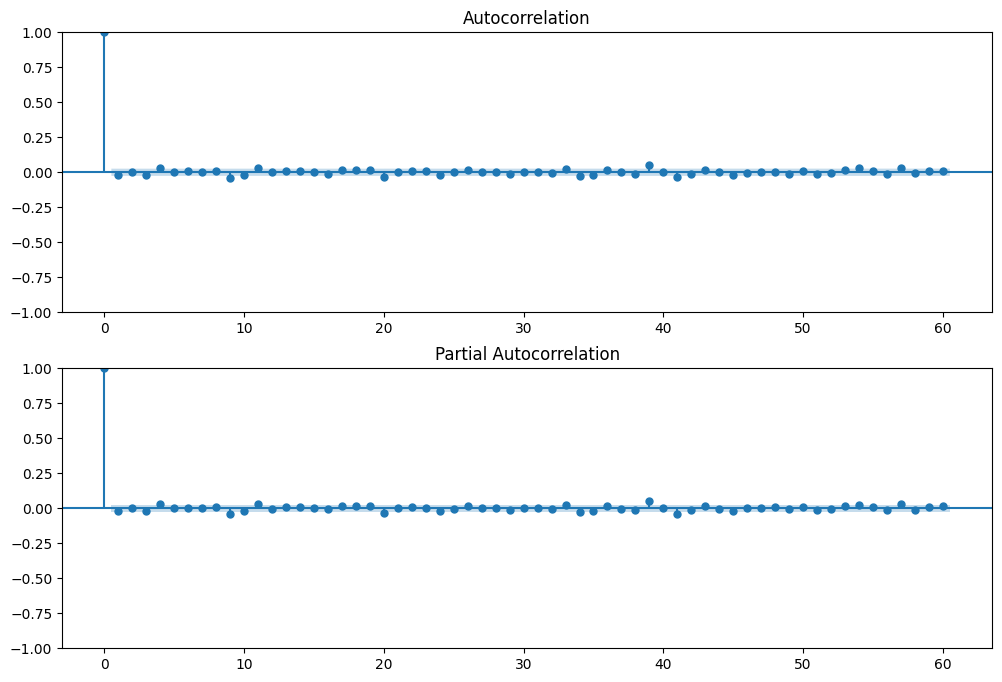

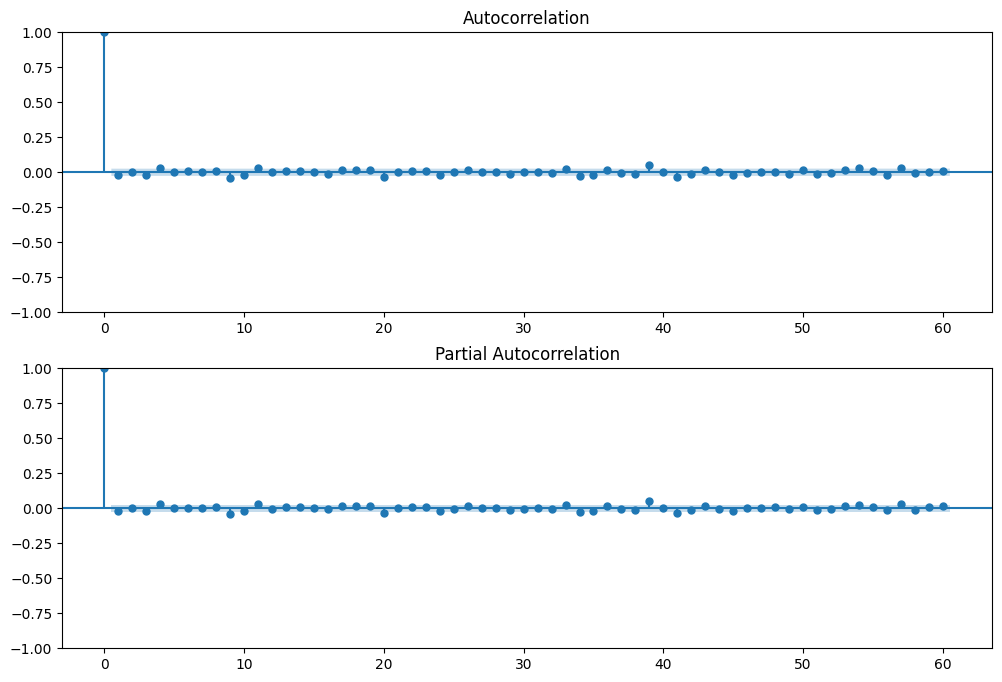

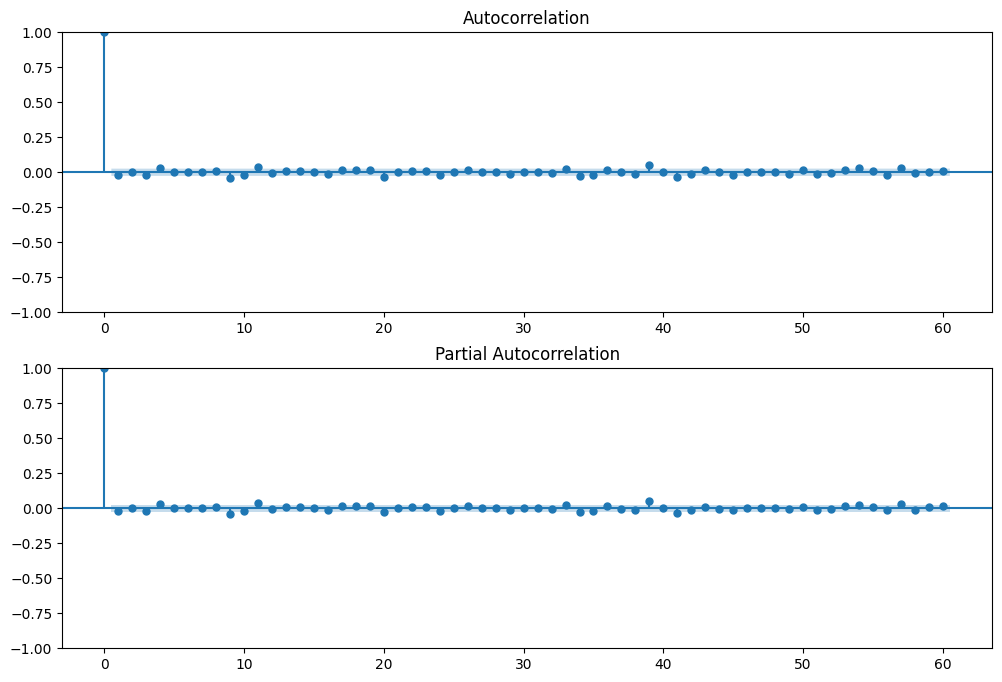

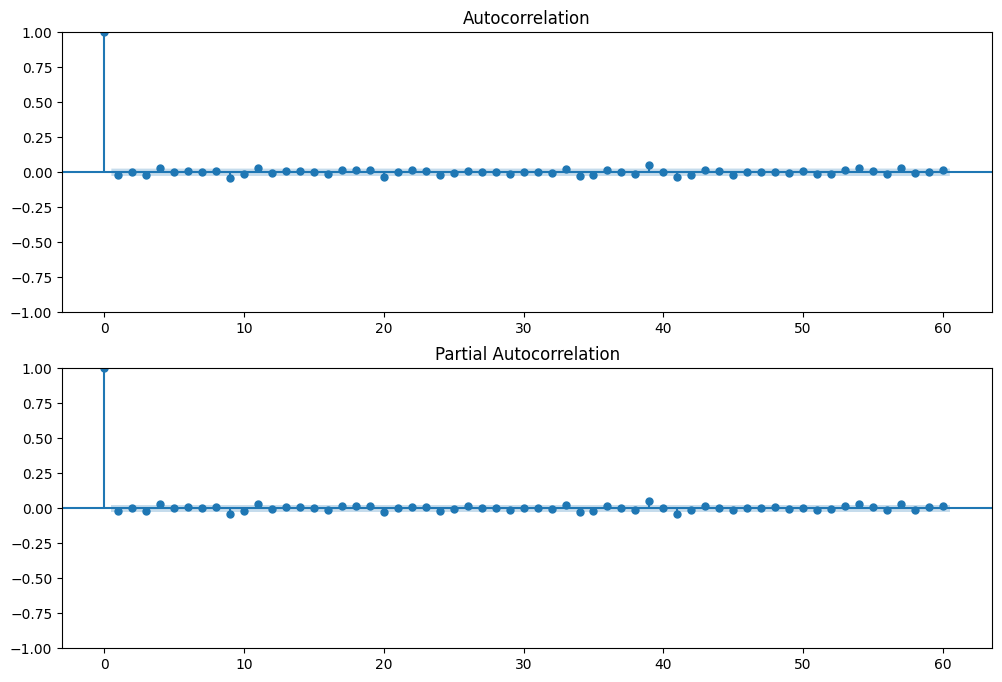

In [14]:
test_obs = [5, 11, 22, 35, 44, 55, 63, 130, 260]

for t in test_obs:
    print("Forecasts ahead:", t)
    train = df_difference['EURUSD'][:-t]
    test = df_difference['EURUSD'][-t:]
    
    lags = 60
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(train.dropna(),lags=lags,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(train.dropna(),lags=lags,ax=ax2)

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5843
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20423.962
Date:                Mon, 05 Feb 2024   AIC                         -40845.924
Time:                        12:55:36   BIC                         -40839.252
Sample:                             0   HQIC                        -40843.604
                               - 5843                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.38e-05   6.74e-07     79.875      0.000    5.25e-05    5.51e-05
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):              1364.32
Prob(Q):                              0.22   Pr

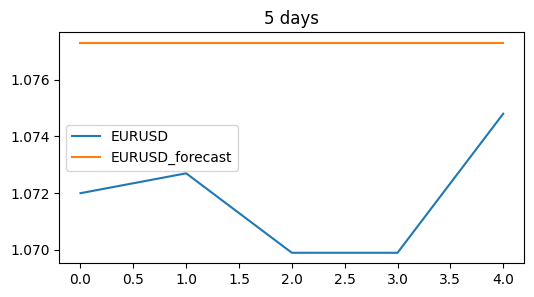

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5837
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20401.630
Date:                Mon, 05 Feb 2024   AIC                         -40801.260
Time:                        12:55:39   BIC                         -40794.588
Sample:                             0   HQIC                        -40798.940
                               - 5837                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.383e-05   6.74e-07     79.834      0.000    5.25e-05    5.52e-05
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):              1362.95
Prob(Q):                              0.21   Pr

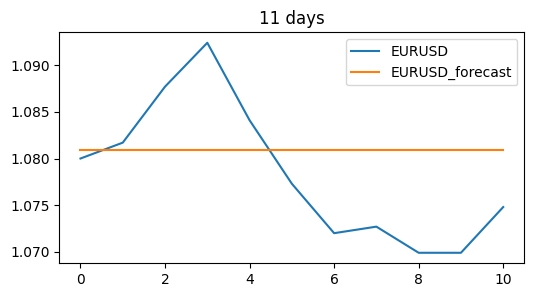

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5826
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20358.554
Date:                Mon, 05 Feb 2024   AIC                         -40715.108
Time:                        12:55:40   BIC                         -40708.438
Sample:                             0   HQIC                        -40712.788
                               - 5826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.391e-05   6.77e-07     79.695      0.000    5.26e-05    5.52e-05
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):              1352.45
Prob(Q):                              0.21   Pr

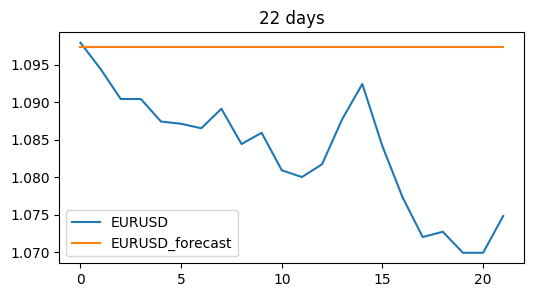

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5813
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20309.258
Date:                Mon, 05 Feb 2024   AIC                         -40616.516
Time:                        12:55:42   BIC                         -40609.848
Sample:                             0   HQIC                        -40614.197
                               - 5813                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.399e-05   6.78e-07     79.575      0.000    5.27e-05    5.53e-05
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              1345.61
Prob(Q):                              0.22   Pr

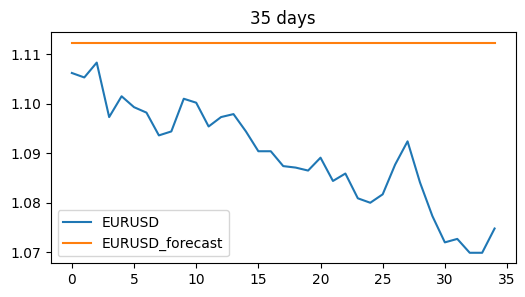

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5804
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20276.085
Date:                Mon, 05 Feb 2024   AIC                         -40550.171
Time:                        12:55:44   BIC                         -40543.504
Sample:                             0   HQIC                        -40547.852
                               - 5804                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.402e-05   6.79e-07     79.513      0.000    5.27e-05    5.53e-05
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):              1343.48
Prob(Q):                              0.21   Pr

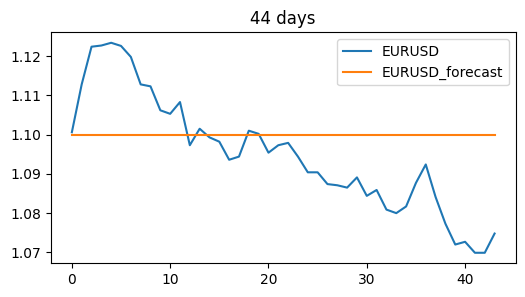

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5793
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20234.622
Date:                Mon, 05 Feb 2024   AIC                         -40467.244
Time:                        12:55:47   BIC                         -40460.580
Sample:                             0   HQIC                        -40464.926
                               - 5793                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.407e-05   6.81e-07     79.422      0.000    5.27e-05    5.54e-05
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):              1339.05
Prob(Q):                              0.20   Pr

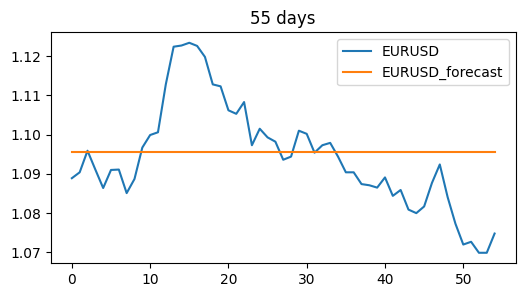

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5785
Model:                 ARIMA(0, 1, 0)   Log Likelihood               20204.680
Date:                Mon, 05 Feb 2024   AIC                         -40407.360
Time:                        12:55:49   BIC                         -40400.697
Sample:                             0   HQIC                        -40405.042
                               - 5785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.411e-05   6.82e-07     79.357      0.000    5.28e-05    5.54e-05
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):              1335.82
Prob(Q):                              0.20   Pr

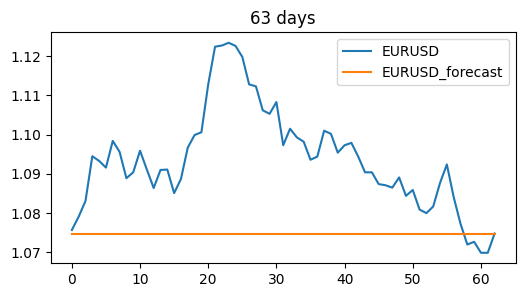

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5718
Model:                 ARIMA(0, 1, 0)   Log Likelihood               19953.836
Date:                Mon, 05 Feb 2024   AIC                         -39905.672
Time:                        12:55:52   BIC                         -39899.020
Sample:                             0   HQIC                        -39903.356
                               - 5718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.443e-05   6.91e-07     78.812      0.000    5.31e-05    5.58e-05
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):              1309.82
Prob(Q):                              0.22   Pr

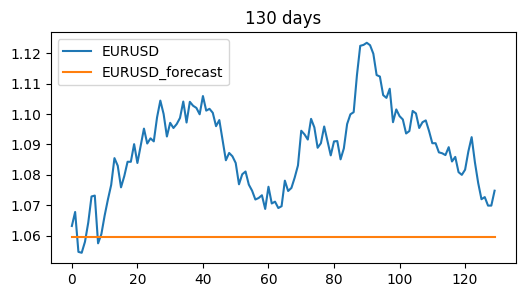

                               SARIMAX Results                                
Dep. Variable:                 EURUSD   No. Observations:                 5588
Model:                 ARIMA(0, 1, 0)   Log Likelihood               19490.186
Date:                Mon, 05 Feb 2024   AIC                         -38978.373
Time:                        12:55:53   BIC                         -38971.745
Sample:                             0   HQIC                        -38976.063
                               - 5588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.462e-05   6.99e-07     78.170      0.000    5.33e-05     5.6e-05
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):              1311.75
Prob(Q):                              0.21   Pr

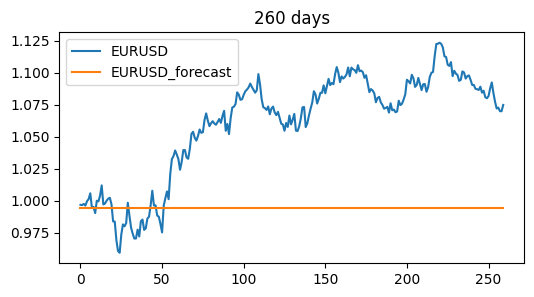

In [31]:
#According to the ACF and PACF plots, we select p=0 and q=0
p_arima = 0
d_arima = 1
q_arima = 0
obs = len(df)
r = 0
pr_tr = {}
means_arima = pd.DataFrame(index=np.arange(len(test_obs)), columns=np.arange(4))
means_arima.rename(columns = {0:'Forecast_days' , 1:'EURUSD', 2: 'EURUSD_forecast', 3: 'MAPE'}, inplace = True)
output_arima = r'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\ARIMA\ARIMA daily'


for t in test_obs:   
    a = obs-t

    model = sm.tsa.arima.ARIMA(df['EURUSD'][:a],order=(p_arima,d_arima,q_arima))

    results = model.fit()
    print(results.summary())
   
    y_pred = pd.Series(results.forecast(t), index=df["EURUSD"][a:].index) 
    y_true = df["EURUSD"][a:]
  
    pred = y_pred.to_frame() 
    pred.rename(columns = {"predicted_mean":'EURUSD_forecast'}, inplace = True)
    true = y_true.to_frame()
        
    pr_tr[r] = pd.merge(pred, true, left_index=True, right_index=True)
    pr_tr[r].reset_index(inplace=True, drop=True)
    pr_tr[r]["EURUSD_MAPE"] = np.nan
    
    for i in range(t):
        pr_tr[r]["EURUSD_MAPE"][i] = np.mean(np.abs(pr_tr[r]['EURUSD_forecast'][i] - pr_tr[r]['EURUSD'][i])/np.abs(pr_tr[r]['EURUSD'][i]))
    
    means_arima["Forecast_days"][r] = t
    means_arima["EURUSD"][r] = pr_tr[r]["EURUSD"].mean()
    means_arima["EURUSD_forecast"][r] = pr_tr[r]["EURUSD_forecast"].mean()
    means_arima["MAPE"][r] = pr_tr[r]["EURUSD_MAPE"].mean()
    
    pr_tr[r]["Day"] = pr_tr[r].index + 1
    pr_tr[r]["EURUSD"].plot(figsize=(6,3),legend=True)
    pr_tr[r]["EURUSD_forecast"].plot(legend=True)   
    pr_tr[r] = pr_tr[r][["Day", "EURUSD", "EURUSD_forecast", "EURUSD_MAPE"]] 
    
    plt.legend()
    plt.title(f'{t} days')
    file_name = f'plot_{t}_days_forecast.png'
    file_path = os.path.join(output_arima, file_name)
    plt.savefig(file_path)
    plt.show()    
    
    r = r + 1

means_arima.head() 

dataframes = [pr_tr[0], 
              pr_tr[1],
              pr_tr[2],
              pr_tr[3],
              pr_tr[4],
              pr_tr[5],
              pr_tr[6],
              pr_tr[7],
              pr_tr[8]]

with pd.ExcelWriter(rf'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\ARIMA\ARIMA daily\EURUSD_ARIMA.xlsx', engine='openpyxl') as writer:
     for i, pr_tr[r] in enumerate(dataframes, start=1):
        sheet_name = f'{len(pr_tr[r])} days forecast'
        pr_tr[r].to_excel(writer, sheet_name=sheet_name, index=False)    
   
     sheet_name = 'Mean forecasts'
     means_arima.to_excel(writer, sheet_name=sheet_name, index=False)         



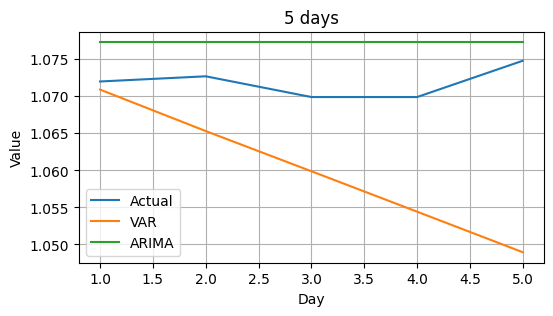

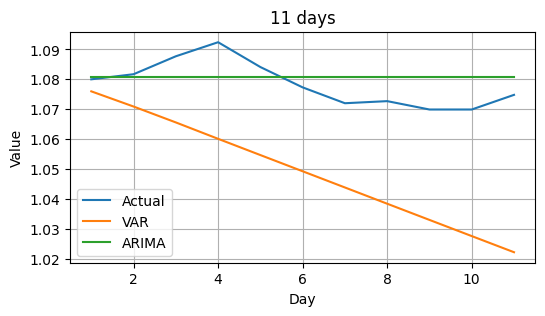

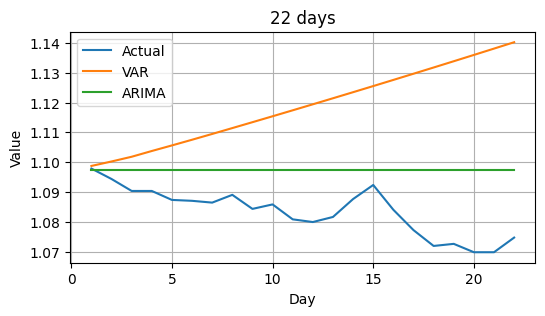

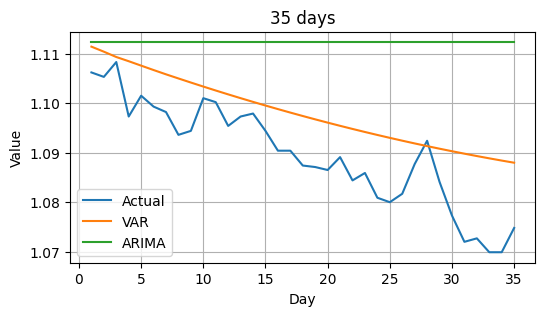

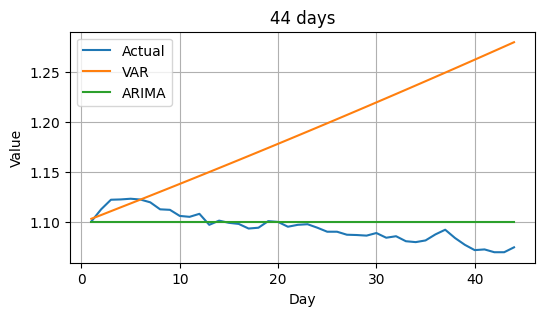

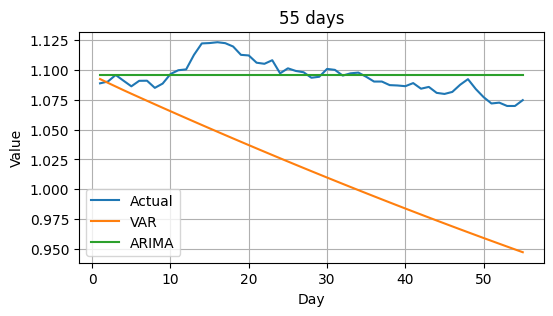

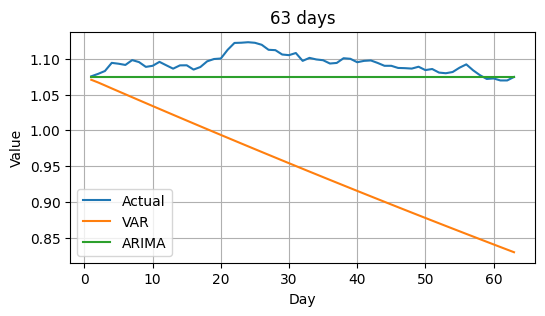

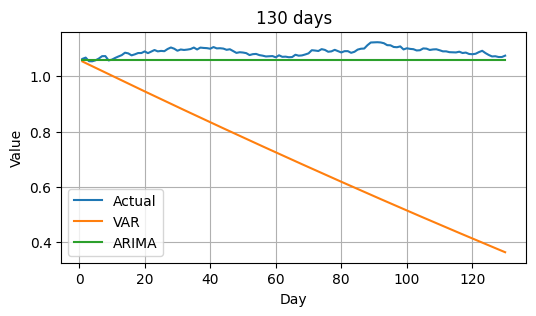

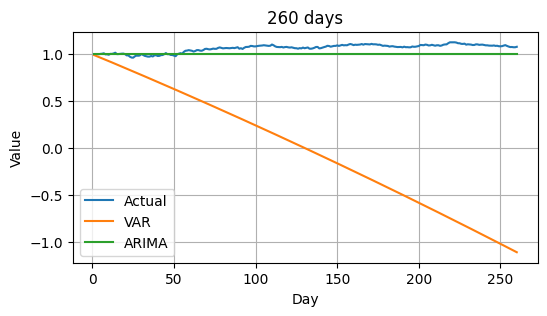

In [32]:
forecasts_eurusd = {}
output_all = r'C:\Users\jim\Dropbox\Sample projects\Forecasting\results\All models'

for r in range(0,9):
    forecasts_eurusd[r] = daily_forecasts[r].copy()
    forecasts_eurusd[r] = forecasts_eurusd[r][["Day", "EURUSD", "EURUSD_forecast"]]
    forecasts_eurusd[r].rename(columns = {'EURUSD':'Actual', 'EURUSD_forecast':'VAR'}, inplace = True)
    forecasts_eurusd[r] = forecasts_eurusd[r].merge(pr_tr[r][["Day", "EURUSD_forecast"]], how = "inner", on = "Day")
    forecasts_eurusd[r].rename(columns = {'EURUSD_forecast':'ARIMA'}, inplace = True)
    
    # Extract the data
    days = forecasts_eurusd[r]["Day"]
    actual = forecasts_eurusd[r]["Actual"]
    var = forecasts_eurusd[r]["VAR"]
    arima = forecasts_eurusd[r]["ARIMA"]

    # Create the plot
    plt.figure(figsize=(6, 3))  # Adjust the figure size as needed
    plt.plot(days, actual, label="Actual")
    plt.plot(days, var, label="VAR")
    plt.plot(days, arima, label="ARIMA")
    
    
    # Add labels and legend
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.title(f'{len(forecasts_eurusd[r])} days')
    file_name = f'plot_{len(forecasts_eurusd[r])}_days_forecast.png'
    file_path = os.path.join(output_all, file_name)
    plt.savefig(file_path)
    plt.show()